# Clasificación de CIFAR-10 en escala de grises con redes neuronales

- Entrenar un modelo de clasificación con una red neuronal feed-forward para clasificar CIFAR-10 en escala de grises.
- Entrenar otro modelo con una red neuronal convolucional para clasificar CIFAR-10 en escala de grises.


## Dataset CIFAR-10 y conversión a escala de grises

El dataset CIFAR-10 es un conjunto de 60.000 imágenes a color de 32x32 píxeles, que contienen 10 clases de objetos.

### CIFAR-10

In [12]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

In [13]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [14]:
print(trainset.data.shape) # 50k imagenes de 32x32x3
imagen0, label = trainset[0] # Cargamos la primera imagen
print(imagen0.shape) # Imagen de 32x32x3 (3 canales RGB)
print(label) # Etiqueta de la imagen
print(trainset.classes[label]) # Nombre de la clase de la imagen

(50000, 32, 32, 3)
torch.Size([3, 32, 32])
6
frog


Classes: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse']


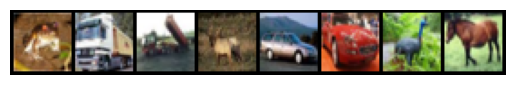

In [15]:
def imshow(img):
    npimg = img.numpy() # Convertimos la imagen a numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Cambiamos el orden de los canales
    plt.axis('off')
    
num_images = 8

# Recuperamos las primeras 5 imágenes y sus etiquetas
first_5_images = [trainset[i][0] for i in range(num_images)]
first_5_labels = [trainset[i][1] for i in range(num_images)]

imshow(torchvision.utils.make_grid(first_5_images))
print(f"Classes: {[trainset.classes[label] for label in first_5_labels]}")

### Transformación a escala de grises

Volvermos a cargar el dataset, esta vez aplicando una transformación para convertir las imágenes a escala de grises (un solo canal).

Files already downloaded and verified
Files already downloaded and verified
torch.Size([1, 32, 32])
frog
Classes: ['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile', 'bird', 'horse']


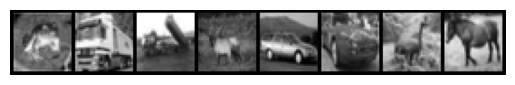

In [16]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Conversión a escala de grises
    transforms.ToTensor(),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

imagen0, label = trainset[0]
print(imagen0.shape) # Ahora un único canal por imagen
print(trainset.classes[label]) # Nombre de la clase de la imagen

first_5_images = [trainset[i][0] for i in range(num_images)]
first_5_labels = [trainset[i][1] for i in range(num_images)]
imshow(torchvision.utils.make_grid(first_5_images))
print(f"Classes: {[trainset.classes[label] for label in first_5_labels]}")

## Preparación

In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

_ = torch.manual_seed(42)

Carga inicial para cálculo de la media y la desviación estándar para normalizar las imágenes:

In [18]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified


In [19]:
sum_ = 0.0
sum_squared = 0.0
num_batches = 0

for data in trainloader:
    images, _ = data
    sum_ += images.sum()
    sum_squared += (images ** 2).sum()
    num_batches += images.size(0) * images.size(2) * images.size(3)

mean = (sum_ / num_batches).item()
std = ((sum_squared / num_batches - mean ** 2) ** 0.5).item()

print(f'Mean: {mean}, Std: {std}')

Mean: 0.48086124658584595, Std: 0.23919044435024261


Nueva carga aplicando modificando el parámetro `transform` con la normalización de las imágenes.

In [20]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Definición de las funciones de entrenamiento y evaluación

In [21]:
def train(dataloader, model, loss_fn, optimizer):    
    model.train()
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

## *Feedforward Neural Network*

In [23]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),   
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),   
            nn.Dropout(0.2),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
fnn = FNN()

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fnn.parameters(), lr=1e-3)

In [25]:
epochs = 10
for t in range(epochs):
    train(trainloader, fnn, loss_fn, optimizer)
    print(f"Epoch {t+1}: ")
    test(testloader, fnn, loss_fn)

Epoch 1: 
Accuracy: 39.3%, Avg loss: 1.711905
Epoch 2: 
Accuracy: 41.9%, Avg loss: 1.610935
Epoch 3: 
Accuracy: 44.0%, Avg loss: 1.565787
Epoch 4: 
Accuracy: 44.6%, Avg loss: 1.558861
Epoch 5: 
Accuracy: 46.8%, Avg loss: 1.513209
Epoch 6: 
Accuracy: 46.8%, Avg loss: 1.504553
Epoch 7: 
Accuracy: 46.9%, Avg loss: 1.502615
Epoch 8: 
Accuracy: 47.6%, Avg loss: 1.500779
Epoch 9: 
Accuracy: 47.7%, Avg loss: 1.483604
Epoch 10: 
Accuracy: 48.5%, Avg loss: 1.483393


## *Convolutional Neural Network* (CNN)

In [26]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 64, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 8 * 8 * 64)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x), dim=1)
    return x
  
cnn = CNN()

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

epochs = 5
for t in range(epochs):
    train(trainloader, cnn, loss_fn, optimizer)
    print(f"Epoch {t+1}: ")
    test(testloader, cnn, loss_fn)

Epoch 1: 
Accuracy: 68.4%, Avg loss: 1.828715
Epoch 2: 
Accuracy: 68.9%, Avg loss: 1.873015
Epoch 3: 
Accuracy: 67.9%, Avg loss: 2.100796
Epoch 4: 
Accuracy: 68.7%, Avg loss: 2.037434
Epoch 5: 
Accuracy: 68.8%, Avg loss: 2.163948


## Fuentes

- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html